## Introduction: 
    Date: January 15, 2014 

    • This dataset is an estimate of gross billings and units sold for each deal that was
    active in XYZ Capital's US segment in Q4 2013.
    
    • Goal:  to use the attached data file to estimate XYZ’s 4Q13 US gross billings by segment
    (Local, Travel, and Goods).Then, using this estimate, make a buy or sell recommendation for XYZ stock,
    pretending it is January 2014, before XYZ Capital reports 4Q13 earnings in February 2014.
    
    
    
     Dataset: First, we will extract data from the excel sheet "Q4 2013 Raw Data" that was provided. 

In [1]:
#import all the necessary packages for data mining and visualization. 
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read from the excel sheet provided and store in a pandas dataframe.

df = pd.read_excel (r'Q4_2013_XYZ.csv')
df.head()

,Deal ID,Units Sold,Billings,Start Date,Deal URL,Segment,Inventory Type
0,gr-millevois-tire-service-center,0.0,0.0,2011-11-21,http://www.xyz.com/deals/gr-millevois-tire-ser...,Local,Third - Party
1,gr-manakeesh-cafe-bakery,0.0,0.0,2011-11-21,http://www.xyz.com/deals/gr-manakeesh-cafe-bakery,Local,Third - Party
2,gr-phoenix-salon-and-spa,0.0,0.0,2011-11-21,http://www.xyz.com/deals/gr-phoenix-salon-and-spa,Local,Third - Party
3,gr-hands-in-motion,0.0,0.0,2011-11-21,http://www.xyz.com/deals/gr-hands-in-motion,Local,Third - Party
4,dc-fd2-bartending-college-allentown-reading,86.8,4253.2,2012-06-06,http://www.xyz.com/deals/dc-fd2-bartending-col...,Local,Third - Party


>  >    ### Performing EDA on the time-series data 

In [3]:
df.describe() # use describe() to calculate statistical data like mean, std and percentile from the data series. 

,Units Sold,Billings
count,138534.000000,1.385340e+05
mean,178.462592,5.500602e+03
std,864.551565,2.774653e+04
min,-9100.000000,-2.180629e+05
25%,1.450000,6.380000e+01
50%,19.200000,8.502000e+02
75%,99.200000,3.677450e+03
max,62500.000000,2.874885e+06


In [4]:
# use value_counts to calculate the inventory type : first-party  and third-party. 
# this is an impportant step to understand XYZ's business as First party means XYZ owns the inventory.

df['Inventory Type'].value_counts()

Third - Party    123911
First - Party     14623
Name: Inventory Type, dtype: int64

In [5]:
# calculate the percentage of what each inventory type constitutes. 

df['Inventory Type'].value_counts(normalize = True)*100

Third - Party    89.444469
First - Party    10.555531
Name: Inventory Type, dtype: float64

<AxesSubplot:xlabel='Inventory Type'>

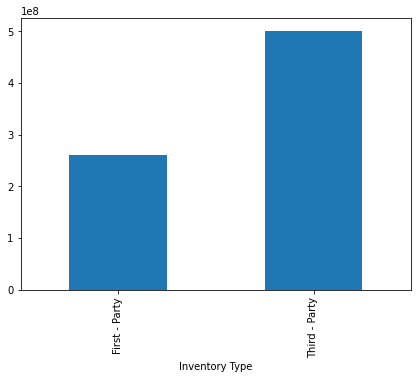

In [6]:
# view the trend for total Billings by first and third parties.

df.groupby('Inventory Type').agg('sum')['Billings'].plot(kind = 'bar',figsize=(7,5))

<AxesSubplot:xlabel='Inventory Type'>

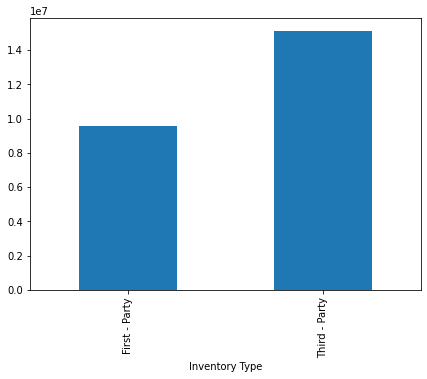

In [7]:
# view the trend for total units sold by first and third parties.

df.groupby('Inventory Type').agg('sum')['Units Sold'].plot(kind = 'bar',figsize=(7,5))

<AxesSubplot:xlabel='Inventory Type'>

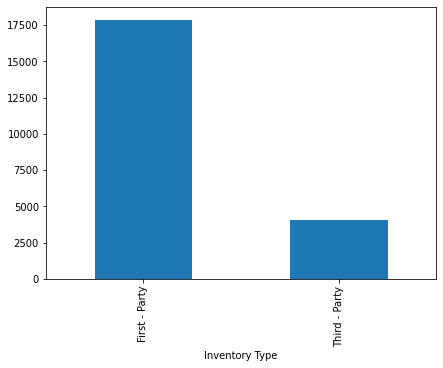

In [8]:
# view the trend for total Billings on average by first and third parties.

df.groupby('Inventory Type').agg('mean')['Billings'].plot(kind = 'bar',figsize=(7,5))

    We saw that there was nothing specific in our EDA above. 
    Only notable was that, the number of third party deals were way higher than that of the first party, 
    while the average billing of the first party deals is higher than that of the third party.
    We will now see monthly data that we have.

In [9]:
# converting Start Date to YYYY-MM format.
df['year_month'] = df['Start Date'].astype(str).str.rsplit('-',1, expand = True)[0]
print(" A glance on Monthly data before preprocessing..")
df['year_month'].value_counts() # value_counts() gives detailed report of the data.

 A glance on Monthly data before preprocessing..


2013-12    23317
2013-11    23046
2013-10    15543
2013-09    13306
2013-08    11071
2013-07     9933
2013-05     9247
2013-04     8125
2013-06     8082
2013-03     5324
2013-02     3555
2013-01     2528
2012-12     2008
2012-11     1647
2012-10     1377
2012-09      379
2012-08       34
2012-07        5
2011-11        4
2012-06        3
Name: year_month, dtype: int64

    As we can see from above that, we don't have enough data for the months of Sept 2012 and before, 
    we will drop them from our dataframe as we preprocess the time series.

In [10]:
# consider data only from sept 1-2012 and later.
df['Start Date'] = pd.to_datetime(df['Start Date']) 
df.sort_values('Start Date', inplace = True)
df = df[df['Start Date']>='2012-09-01']

### Working on deal IDs :

    The given raw data set includes zero Local deals from October 20 to October 2013. 
    We need to adjust the unique number of new deals that were started in those 10 days. 
    Performing EDA on the deals data:

In [11]:
# make a Dataframe which has unique deal IDs, grouped by Start Date. 
df_deals = df.groupby(['Segment', 'Start Date'])['Deal ID'].nunique().reset_index()
# make a Dataframe which has unique deal IDs, grouped by YYYY-MM. 
df_deals1 = df.groupby(['Segment', 'year_month'])['Deal ID'].nunique().reset_index()

In [12]:
print("Printing the unique deal IDs by Start Date..")
df_deals.head()

Printing the unique deal IDs by Start Date..


,Segment,Start Date,Deal ID
0,Goods,2012-10-30,1
1,Goods,2013-03-25,3
2,Goods,2013-03-26,2
3,Goods,2013-03-27,2
4,Goods,2013-03-28,1


In [13]:
print("Printing the unique deal IDs by YYYY-MM..")
df_deals1.head()

Printing the unique deal IDs by YYYY-MM..


,Segment,year_month,Deal ID
0,Goods,2012-10,1
1,Goods,2013-03,17
2,Goods,2013-04,323
3,Goods,2013-05,367
4,Goods,2013-06,369


In [14]:
# make a new dataframe for Q4 2013.
new_deals_df = df_deals1[((df_deals1['year_month'] == '2013-10') | (df_deals1['year_month'] == '2013-11') | 
          (df_deals1['year_month'] == '2013-12')) & (~(df_deals1['Segment'] == 'Local'))]

Plotting the unique Local deal IDs..


<AxesSubplot:xlabel='Start Date'>

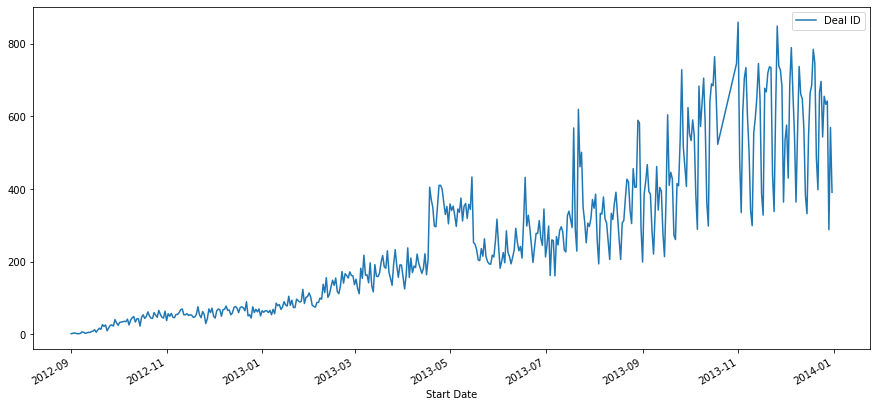

In [15]:
print("Plotting the unique Local deal IDs..")
df_deals[df_deals['Segment'] == 'Local'].set_index('Start Date').plot(figsize=(15,7))

Plotting a histogram for the unique Local deal IDs..


<AxesSubplot:xlabel='year_month'>

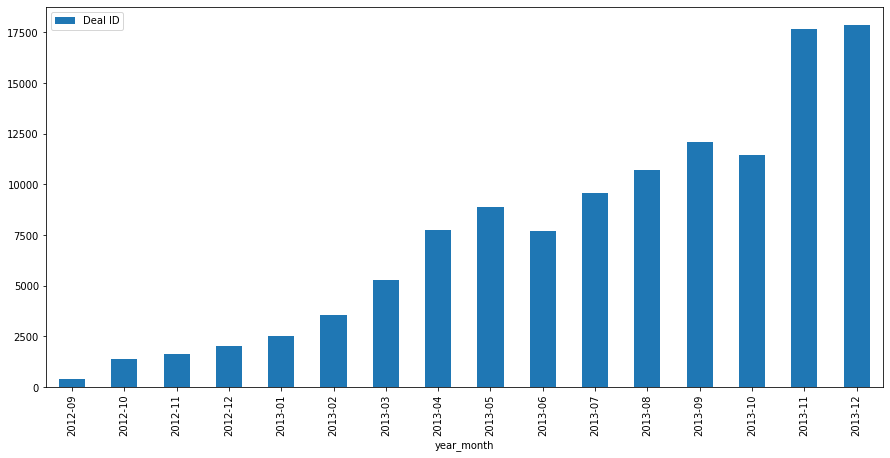

In [16]:
print("Plotting a histogram for the unique Local deal IDs..")
df_deals1[df_deals1['Segment'] == 'Local'].set_index('year_month').plot(kind = 'bar',figsize=(15,7))

 - Now, we can infer that the trend for monthly deals is increasing upwards, but decreases quite a bit in October
 2013.
 - Given that the data for the 11 days was missing, we will use a simple interpolation method to adjust the data as it seems to be a linear regression model. 
 

In [17]:
# setting the model for interpolation.
df_deals1 = df_deals1[df_deals1['Segment'] == 'Local'].set_index('year_month')

In [18]:
import numpy as np
# fill the gaps with nan values in the dataframe. 
df_deals1.loc['2013-10','Deal ID'] = np.nan

 Finally, we have arrived to better fit model..


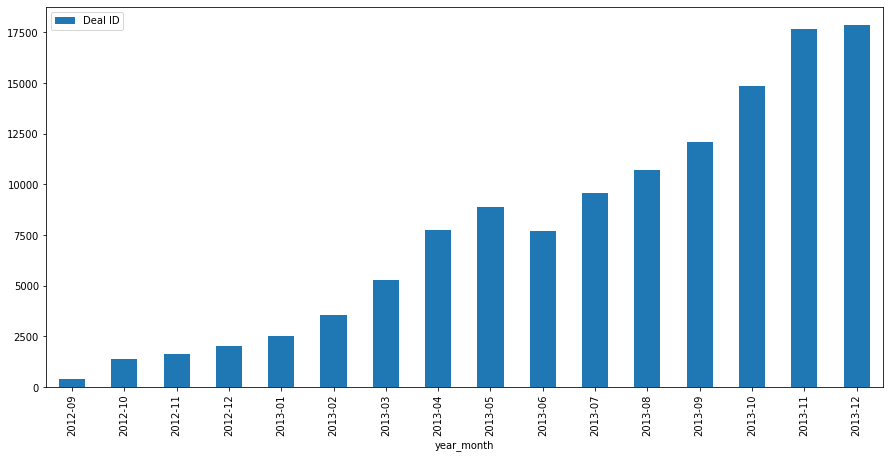

In [19]:
# use interpolate() method and plot the data to validate. 
df_deals1.interpolate().plot(kind = 'bar',figsize=(15,7))
print(" Finally, we have arrived to better fit model..")

In [20]:
print("Interpolating the Deal IDs..")
# final values for all the deals that we estimated.
df_deals1.interpolate()

Interpolating the Deal IDs..


,Segment,Deal ID
year_month,,
2012-09,Local,379.0
2012-10,Local,1376.0
2012-11,Local,1647.0
2012-12,Local,2008.0
2013-01,Local,2528.0
2013-02,Local,3555.0
2013-03,Local,5306.0
2013-04,Local,7776.0
2013-05,Local,8874.0


In [21]:
# append the Locals data in the new deals dataframe. 
new_deals_df = new_deals_df.append(df_deals1.interpolate().loc[['2013-10', '2013-11', '2013-12']].reset_index())

In [22]:
print("Q4 2013 data for New Deals Started..")
new_deals_df

Q4 2013 data for New Deals Started..


,Segment,year_month,Deal ID
8,Goods,2013-10,3648.0
9,Goods,2013-11,4520.0
10,Goods,2013-12,4581.0
34,Travel,2013-10,466.0
35,Travel,2013-11,855.0
36,Travel,2013-12,856.0
0,Local,2013-10,14874.5
1,Local,2013-11,17671.0
2,Local,2013-12,17880.0


###  Data irregularities :

    It was noted in the assignment that the system that finds the deals on the XYZ Capital US website and
    adds them to the database broke from October 20 to October 30 2013 (inclusive). 
    Hence, to take care of all the missed billings from deals that started during this period but remained active
    after the period, We need to adjust the data (assuming we have 100% of any other data for other months)to deal
    with this outage by making an estimate for US
    Q4 2013 billings by segment. 
    
#### Imputation of the missing values :

    Aggregate for daily "Billings" with respect to their "Segments" is calculated and stored in a dataframe.
    The purpose is to perform forecasting on this data separately.

In [23]:
# truncate the time-date to just having the dates as no time was actually recorded.
# We just use the dates in YYYY-MM-DD format.

df['Start Date'] = pd.to_datetime(df['Start Date']) 
# sort Dataframe wrt dates. 
df.sort_values('Start Date', inplace = True)
# 
df = df[df['Start Date']>='2012-09-01']

In [24]:
# splitting the dataframe to just the columns that we need for Time-series data imputation.
agg_df = df.groupby(['Segment', 'Start Date']).agg('sum')
agg_df

Units Sold      Billings
Segment Start Date                          
Goods   2012-10-30     663.918   12443.59800
        2013-03-25       6.670     286.74330
        2013-03-26      -9.476    -894.60524
        2013-03-27      69.046    2565.74154
        2013-03-28       1.334      11.99266
...                        ...           ...
Travel  2013-12-27    5232.150  537456.35000
        2013-12-28    3602.300  574718.36500
        2013-12-29     729.450  140518.70000
        2013-12-30     634.800  112151.95000
        2013-12-31    1359.650  196439.12500

[882 rows x 2 columns]

## Modelling and Forecasting the data :

    Since the data is heavily dependent on time, meaning, it was collected at different points in time, 
    we determined that the data is Time-series data. 
    Accordingly, we will confidently use classical and naive methods like SARIMA and Holt-Winters models to 
    to develop robust estimation models. 

### Machine learning models on time-series forecasting we will try: 
        • SARIMA Model 
        • Holt-Winters Model

### Data preparation for modelling techniques :

    We will have to split the time-series data into train and test data sets. 
    For that, we will have to refer the plots for both the trends in "Billings" and "Units Sold". 

In [25]:
# This is our base-model dataframe where we resample the time-series by day. 
model_df = agg_df.loc['Local'].resample('D').mean()

Units Sold trend on October data..


<AxesSubplot:xlabel='Start Date'>

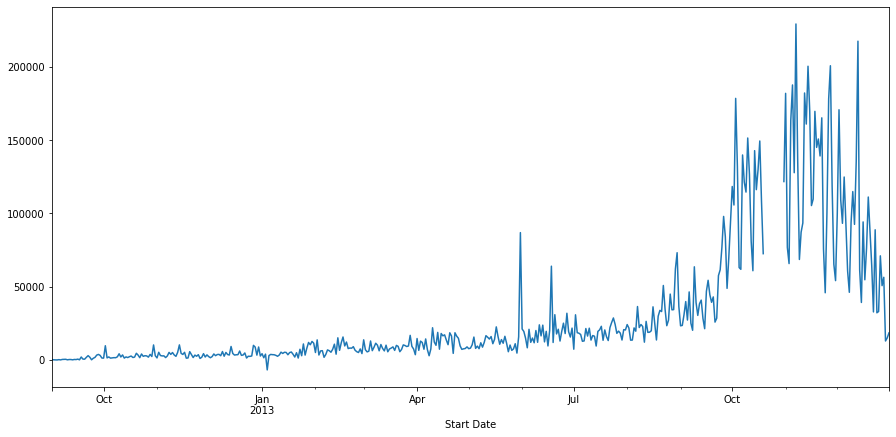

In [26]:
print("Units Sold trend on October data..")
# Let's plot the dataframe by "Units Sold" column. 
model_df['Units Sold'].plot(figsize=(15,7))

Billings trend on October data..


<AxesSubplot:xlabel='Start Date'>

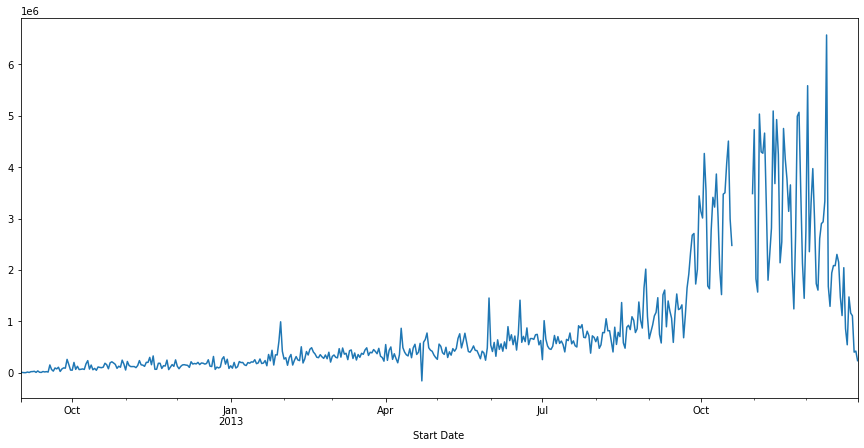

In [27]:
print("Billings trend on October data..")
# Let's plot the dataframe by "Billings" column. 
model_df['Billings'].plot(figsize=(15,7))

    We can see discontinuation in both the plots. 
    We will have to fill in these gaps in both the columns due to their time-dependent nature. 

In [28]:
# first, reset the index to be the Start Date column for easier data manipulation. 
model_df.reset_index(inplace = True)
# to verify if we filled in the discontinuation in the data for the missing dates.
model_df.iloc[410:430]

,Start Date,Units Sold,Billings
410,2013-10-16,129796.00,4.072212e+06
411,2013-10-17,149366.45,4.507996e+06
412,2013-10-18,108156.45,2.991175e+06
413,2013-10-19,72507.15,2.477089e+06
414,2013-10-20,NaN,NaN
415,2013-10-21,NaN,NaN
416,2013-10-22,NaN,NaN
417,2013-10-23,NaN,NaN
418,2013-10-24,NaN,NaN
419,2013-10-25,NaN,NaN


In [29]:
# splitting the train data from all the period before 20th October, where all data was present. 
train_data = model_df[model_df['Start Date'] < '2013-10-20']
# splitting the test data from all the period after 20th October. 
test_data = model_df[model_df['Start Date'] >= '2013-10-20']

In [30]:
# print the train_data
print("An overview of the train data..")
train_data.head()

An overview of the train data..


,Start Date,Units Sold,Billings
0,2012-09-01,282.05,3778.15
1,2012-09-02,98.10,4218.30
2,2012-09-03,15.35,4.45
3,2012-09-04,0.00,0.00
4,2012-09-05,218.40,11960.40


In [31]:
# we will further split the train and test data sets by individual series.
units_train_data = train_data[['Start Date', 'Units Sold']]
units_test_data = test_data[['Start Date', 'Units Sold']]
billings_train_data = train_data[['Start Date', 'Billings']]
billings_test_data = test_data[['Start Date', 'Billings']]
   

### Simple Exponential Smoothing Model : 
    To build Holt-Winters Model, we will first have to try building a Simple Exponential Smoothing Model.
    By building an Exponential Model, we assign exponentially decreasing weights to the past observations. 
    This helps to observe trends for the most recent observations and their heights. 

In [32]:
# import python libraries for Simple Exp Smoothing. 
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

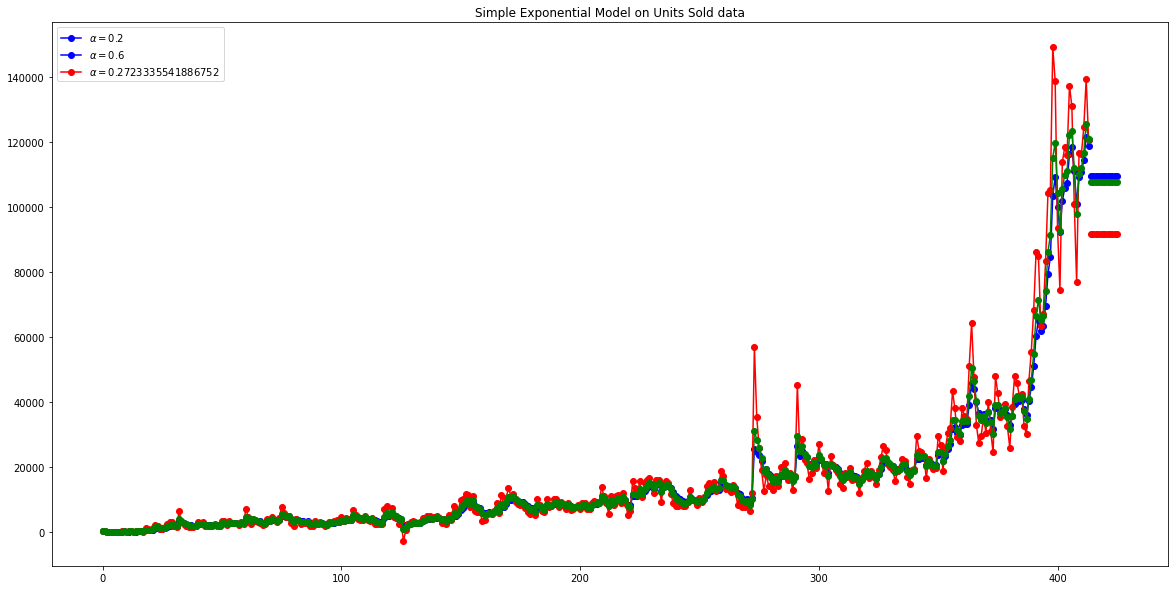

In [33]:
# use Simple Exponential Smoothing technique.
plt.figure(figsize=(20,10))
# fit the train data.
fit1 = SimpleExpSmoothing(units_train_data['Units Sold']).fit(smoothing_level=0.2,optimized=False)
# 
fcast1 = fit1.forecast(12).rename(r'$\alpha=0.2$')
# plot the model.
fcast1.plot(marker='o', color='blue', legend=True)
fit1.fittedvalues.plot(marker='o',  color='blue')


# fit the train data.
fit2 = SimpleExpSmoothing(units_train_data['Units Sold']).fit(smoothing_level=0.6,optimized=False)
fcast2 = fit2.forecast(12).rename(r'$\alpha=0.6$')
# plot the model.
fcast2.plot(marker='o', color='red', legend=True)
fit2.fittedvalues.plot(marker='o', color='red')

# fit the train data.
fit3 = SimpleExpSmoothing(units_train_data['Units Sold']).fit()
fcast3 = fit3.forecast(12).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])
# plot the model.
fcast3.plot(marker='o', color='green', legend=True)
fit3.fittedvalues.plot(marker='o', color='green')
plt.title("Simple Exponential Model on Units Sold data")
plt.show()


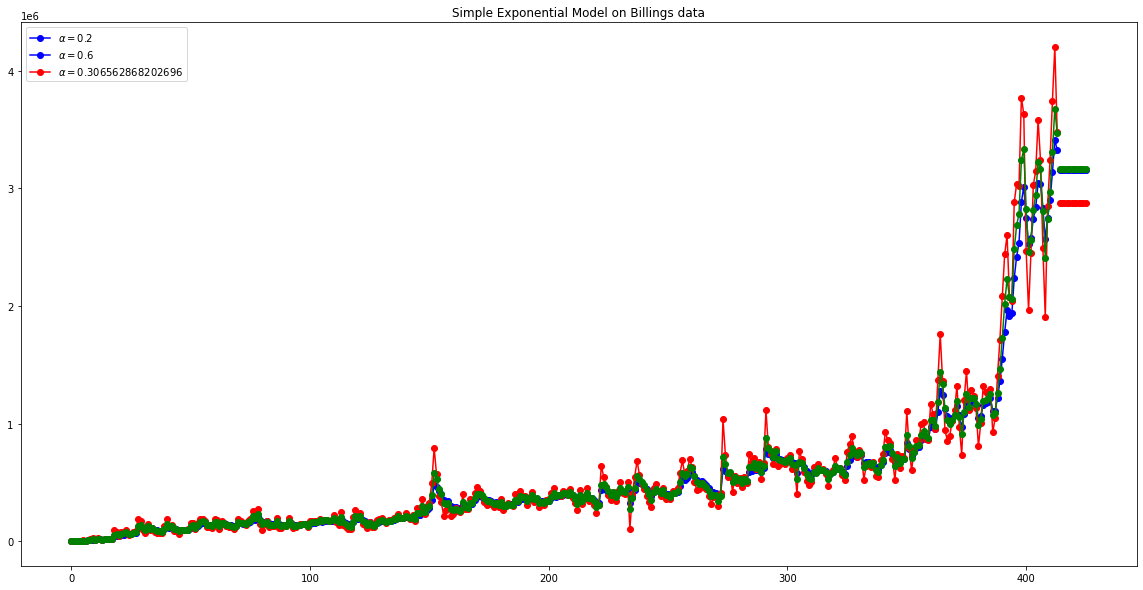

In [34]:
# use Simple Exponential Smoothing technique.
plt.figure(figsize=(20,10))
# fit the train data.
fit1 = SimpleExpSmoothing(billings_train_data['Billings']).fit(smoothing_level=0.2,optimized=False)
fcast1 = fit1.forecast(12).rename(r'$\alpha=0.2$')
# plot the model.
fcast1.plot(marker='o', color='blue', legend=True)
fit1.fittedvalues.plot(marker='o',  color='blue')


# fit the train data.
fit2 = SimpleExpSmoothing(billings_train_data['Billings']).fit(smoothing_level=0.6,optimized=False)
fcast2 = fit2.forecast(12).rename(r'$\alpha=0.6$')
# plot the model.
fcast2.plot(marker='o', color='red', legend=True)
fit2.fittedvalues.plot(marker='o', color='red')


# fit the train data.
fit3 = SimpleExpSmoothing(billings_train_data['Billings']).fit()
fcast3 = fit3.forecast(12).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])
# plot the model.
fcast3.plot(marker='o', color='green', legend=True)
fit3.fittedvalues.plot(marker='o', color='green')
plt.title("Simple Exponential Model on Billings data")
plt.show()

    As we could observe, from above plots, that the estimated trends (in red, blue and green) for the missing 
    October data were not very consistent with the previous data trends, the Simple Exponential Smoothing 
    model won't work out for an accurate estimation. 
    We will now try Holt method:

### Holt Method: 

    Holt's method is an extension to the Exponential Smoothing method with two variations: 
     - Additive method 
     - Multiplicative method 
     Both of these methods allow us to use seasonal variations observed in trends that are constant through 
     the series.

In [35]:
#checking data irregularities, viz., negatives and zeroes for Holts.
units_train_data.loc[units_train_data['Units Sold']<=0 ,'Units Sold'].shape

(2,)

In [36]:
# Holt-Winters won't work on 0 and negative values so we re-assign them to 1. 
# Reassigning them to 1 won't make much a difference as there are just 2 such values.
units_train_data.loc[units_train_data['Units Sold']<=0 ,'Units Sold'] = 1

/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


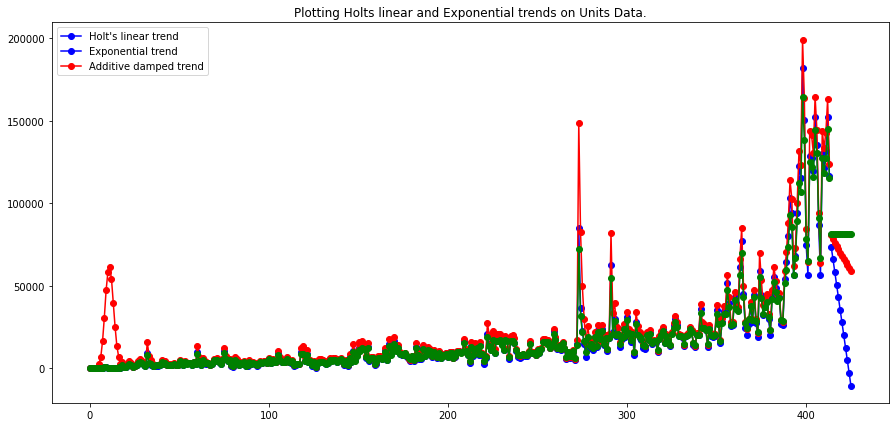

In [37]:
# fit the model.
fit1 = Holt(units_train_data['Units Sold']).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast1 = fit1.forecast(12).rename("Holt's linear trend")

# fit the model.
fit2 = Holt(units_train_data['Units Sold'], exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast2 = fit2.forecast(12).rename("Exponential trend")

# fit the model.
fit3 = Holt(units_train_data['Units Sold'], damped=True).fit(smoothing_level=0.8, smoothing_slope=0.2)
fcast3 = fit3.forecast(12).rename("Additive damped trend")

# plot the fit model. 
plt.figure(figsize=(15,7))
fit1.fittedvalues.plot(marker="o", color='blue')
fcast1.plot(color='blue', marker="o", legend=True)
fit2.fittedvalues.plot(marker="o", color='red')
fcast2.plot(color='red', marker="o", legend=True)
fit3.fittedvalues.plot(marker="o", color='green')
fcast3.plot(color='green', marker="o", legend=True)

plt.title("Plotting Holts linear and Exponential trends on Units Data.")
plt.show()

In [38]:
#checking data irregularities, viz., negatives and zeroes for Holts.
billings_train_data.loc[billings_train_data['Billings']<=0 ,'Billings'] = 1

/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


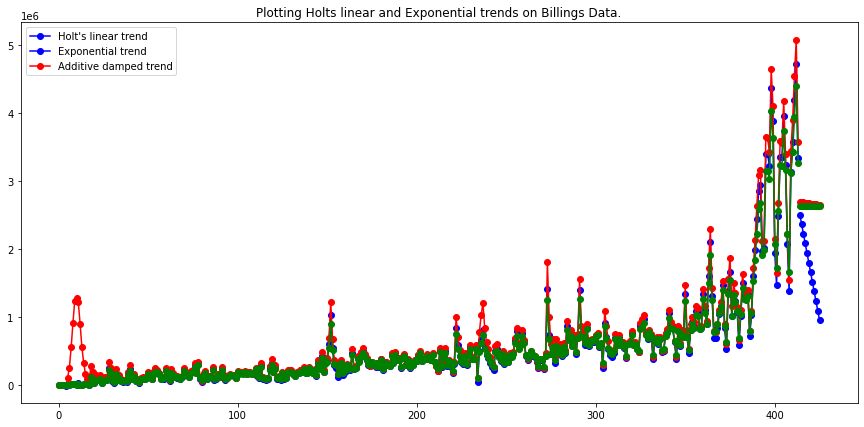

In [39]:
# fit the model.
fit1 = Holt(billings_train_data['Billings']).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast1 = fit1.forecast(12).rename("Holt's linear trend")

# fit the model.
fit2 = Holt(billings_train_data['Billings'], exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast2 = fit2.forecast(12).rename("Exponential trend")

# fit the model.
fit3 = Holt(billings_train_data['Billings'], damped=True).fit(smoothing_level=0.8, smoothing_slope=0.2)
fcast3 = fit3.forecast(12).rename("Additive damped trend")

# plot the fit model. 
plt.figure(figsize=(15,7))
fit1.fittedvalues.plot(marker="o", color='blue')
fcast1.plot(color='blue', marker="o", legend=True)
fit2.fittedvalues.plot(marker="o", color='red')
fcast2.plot(color='red', marker="o", legend=True)
fit3.fittedvalues.plot(marker="o", color='green')
fcast3.plot(color='green', marker="o", legend=True)

plt.title("Plotting Holts linear and Exponential trends on Billings Data.")
plt.show()

    After applying Holt method, we could observe some trends, but not satisfactory.
    Hence, we will move further to applying Holt-Winters Model.


### Holt-Winters Seasonal Method :
    Holt-Winters’ Method is another model which is suitable for data with both trends and seasonalities.
    Let's find out if we get results as per our requirements. 
    
    Starting with training the model on "Units Sold" data.

In [40]:
# fit the model by adding seasonality as 30 as we use monthly data and adding additive..
# and multiplicative trends as well. 

fit1 = ExponentialSmoothing(units_train_data['Units Sold'], seasonal_periods=30, trend='add', seasonal='add').fit(use_boxcox=True)
fit2 = ExponentialSmoothing(units_train_data['Units Sold'], seasonal_periods=30, trend='mul', seasonal='add').fit(use_boxcox=True)
fit3 = ExponentialSmoothing(units_train_data['Units Sold'], seasonal_periods=30, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
fit4 = ExponentialSmoothing(units_train_data['Units Sold'], seasonal_periods=30, trend='mul', seasonal='add', damped=True).fit(use_boxcox=True)


/usr/local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


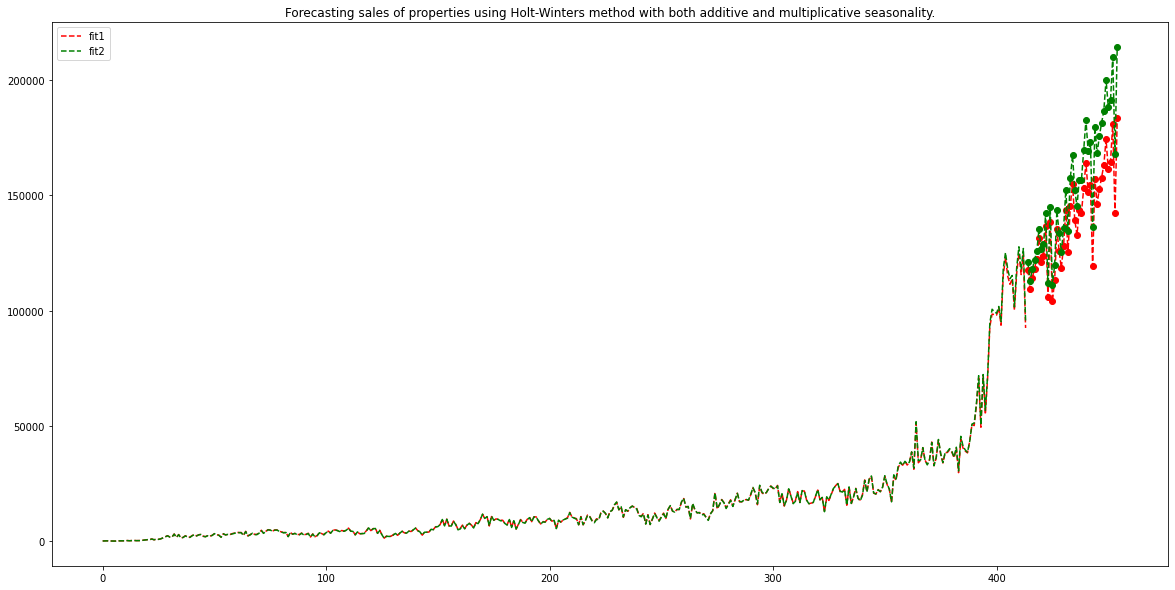

In [41]:
# we will choose the best fit models. 
fit1.fittedvalues.plot(style='--', color='red', figsize=(20,10))
fit2.fittedvalues.plot(style='--', color='green',figsize=(20,10))

# here we chose fit1 and fit2 to get results from them.
fit1.forecast(41).plot(style='--', marker='o', color='red', label='fit1', legend=True, figsize=(20,10))
fit2.forecast(41).plot(style='--', marker='o', color='green', label='fit2', legend=True, figsize=(20,10))
# plotting only to choose the best fit models.
plt.title("Forecasting sales of properties using Holt-Winters method with both additive and multiplicative seasonality.")
plt.show()

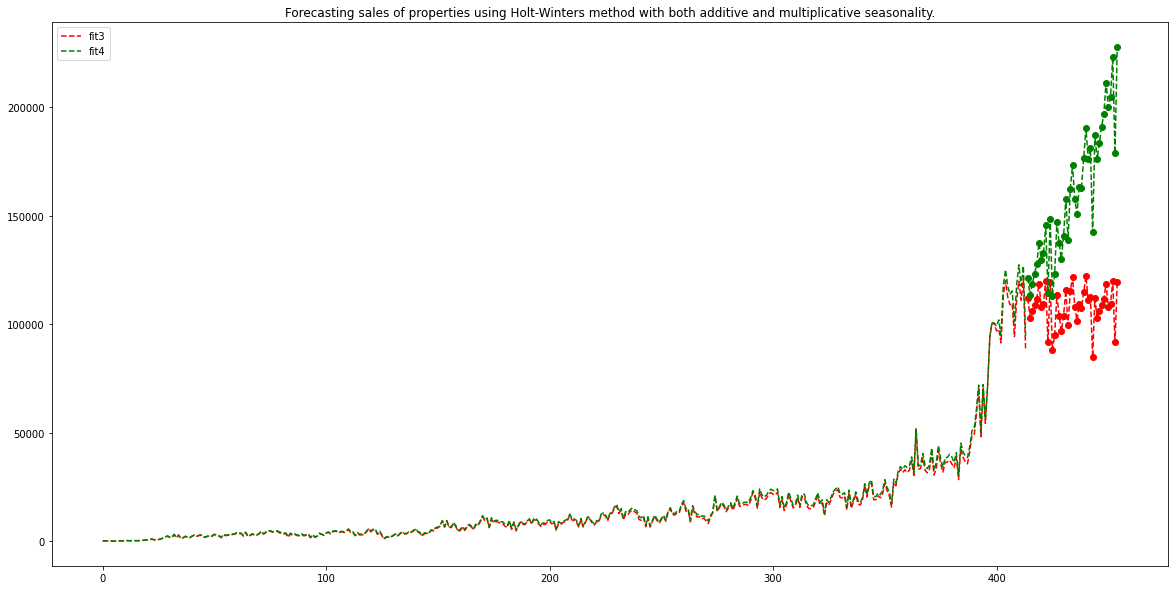

In [42]:
# here we chose fit3 and fit4 to get results from them.
fit3.fittedvalues.plot(style='--', color='red', figsize=(20,10))
fit4.fittedvalues.plot(style='--', color='green',figsize=(20,10))

fit3.forecast(41).plot(style='--', marker='o', color='red', label='fit3',legend=True, figsize=(20,10))
fit4.forecast(41).plot(style='--', marker='o', color='green', label='fit4',legend=True, figsize=(20,10))
# plotting only to choose the best fit models.
plt.title("Forecasting sales of properties using Holt-Winters method with both additive and multiplicative seasonality.")
plt.show()

    From above two plots for Holt-Winters method and verifying the rmse values for all the fits at the 
    back-end, we infer that fit-3 had the most reliable results on train-data for Units. So, we choose 
    this fit for our test-data.

In [43]:
# fit the model on fit3.
test_data['Units_forecast_Holt'] = fit3.forecast(72)
predictions=test_data.loc[:455 , 'Units_forecast_Holt']
test=(units_test_data.loc[:455,'Units Sold'])
train = units_train_data['Units Sold']

<ipython-input-43-73015ff3df6a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Units_forecast_Holt'] = fit3.forecast(72)


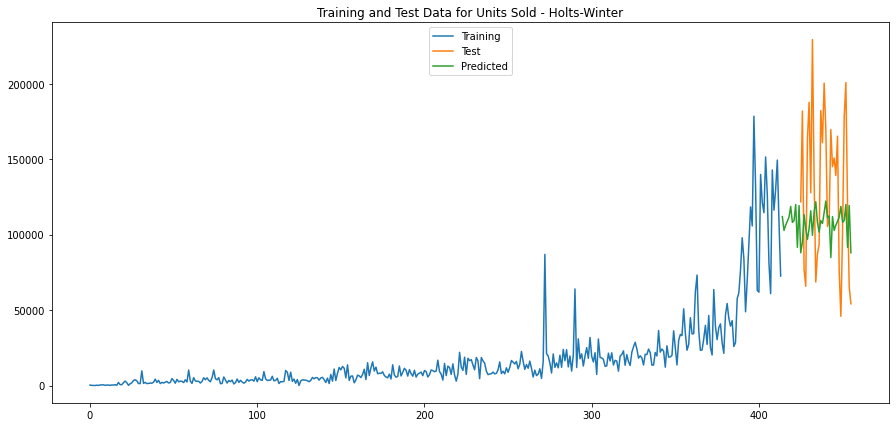

In [44]:
# plot the train and test data using matplotlib.
plt.figure(figsize=(15,7))
plt.plot(train, label='Training')
plt.plot(test, label='Test')
plt.plot(predictions, label='Predicted')
plt.legend(loc = 'upper center')
plt.title("Training and Test Data for Units Sold - Holts-Winter")
plt.show()

### Evaluating Regression models in Machine Learning :
    One of the finest methods to determine the accuracy of predictive models is evaluating the RMSE.
   * RMSE = Root Mean Squared Error 
 
  RMSE = $\sqrt{MSE}$ = $ \sqrt {\frac {\sum_{i=1}^{N} (Predictions - Test)^2} {N}}$
  


In [45]:
# make a DataFrame to record rmse for each series, as we train and predict models. 
rmse_df = pd.DataFrame()

In [46]:
# evaluating the accuracy with rmse.
# we can also use a mean instead of summing them and dividing by N, easier for readability.
rmse = ((predictions - test) ** 2).mean() ** .5
rmse_df.loc['Holts-Winter', 'Units_Sold'] = round(rmse)
print("rmse for units sold via Holt-winters :", round(rmse))

rmse for units sold via Holt-winters : 56530


        Similarly, we will train the model on "Billings" data using Holt-Winters.

In [47]:
# fit the model by adding seasonality as 14 as we use by-weekly data and adding additive..
# and multiplicative trends as well.
fit1 = ExponentialSmoothing(billings_train_data['Billings'], seasonal_periods=14, trend='add', seasonal='add').fit(use_boxcox=True)
fit2 = ExponentialSmoothing(billings_train_data['Billings'], seasonal_periods=14, trend='mul', seasonal='add').fit(use_boxcox=True)
fit3 = ExponentialSmoothing(billings_train_data['Billings'], seasonal_periods=14, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
fit4 = ExponentialSmoothing(billings_train_data['Billings'], seasonal_periods=14, trend='mul', seasonal='add', damped=True).fit(use_boxcox=True)


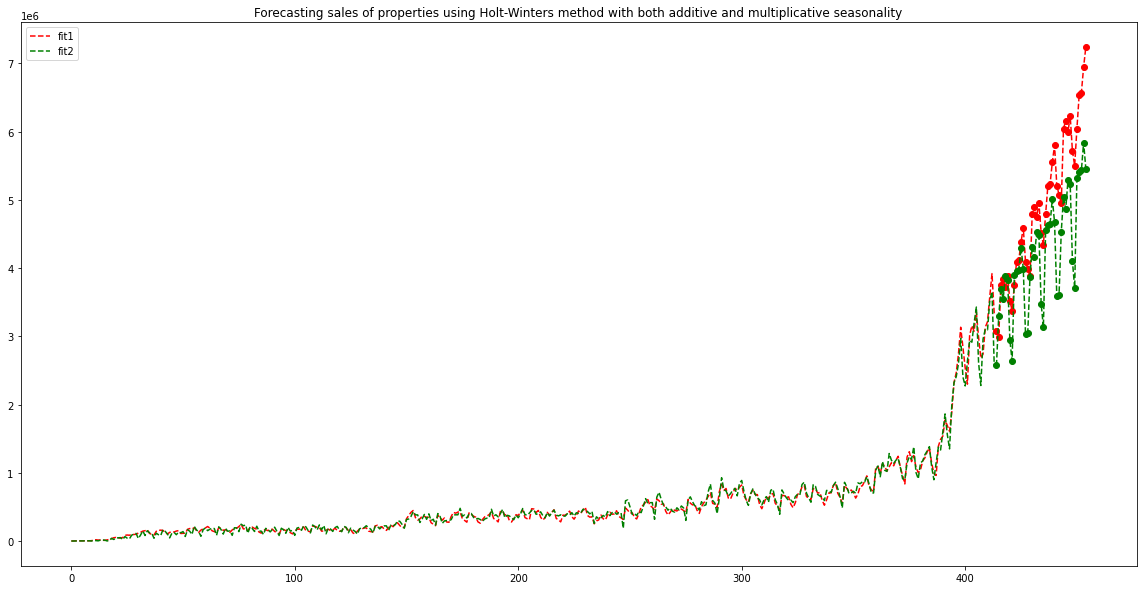

In [48]:
# we will choose the best fit models. 
fit1.fittedvalues.plot(style='--', color='red', figsize=(20,10))
fit2.fittedvalues.plot(style='--', color='green',figsize=(20,10))

# here we chose fit1 and fit2 to get results from them.
fit1.forecast(41).plot(style='--', marker='o', color='red', label='fit1',legend=True, figsize=(20,10))
fit2.forecast(41).plot(style='--', marker='o', color='green', label='fit2', legend=True, figsize=(20,10))
# plotting only to choose the best fit models.
plt.title("Forecasting sales of properties using Holt-Winters method with both additive and multiplicative seasonality")
plt.show()

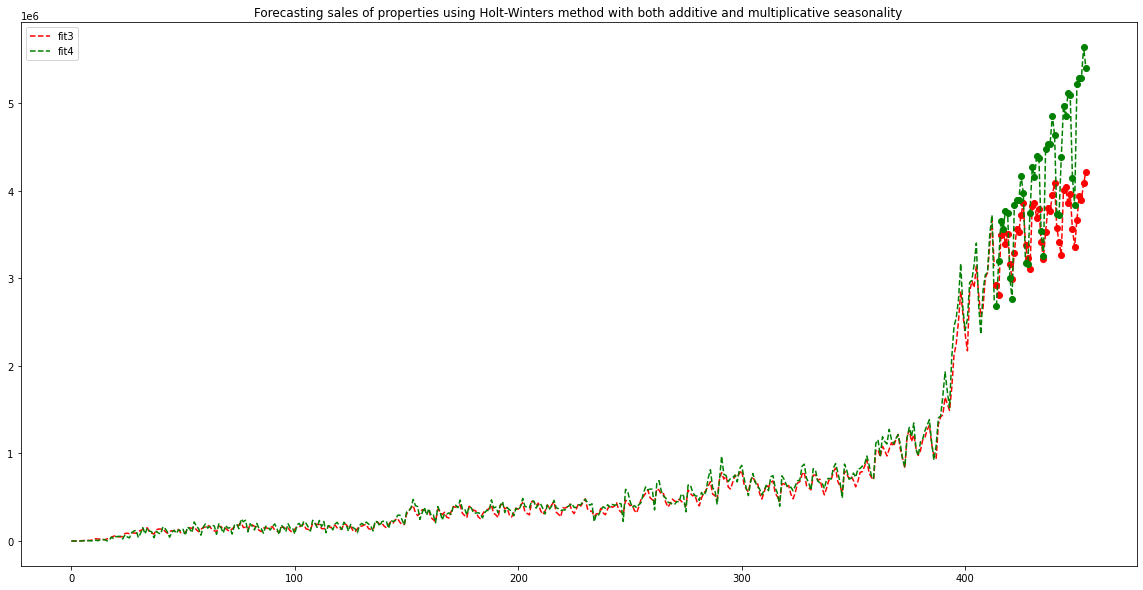

In [49]:
# here we chose fit3 and fit4 to get results from them.
fit3.fittedvalues.plot(style='--', color='red', figsize=(20,10))
fit4.fittedvalues.plot(style='--', color='green',figsize=(20,10))

# plotting only to choose the best fit models.
fit3.forecast(41).plot(style='--', marker='o', color='red', label='fit3',legend=True, figsize=(20,10))
fit4.forecast(41).plot(style='--', marker='o', color='green',label='fit4', legend=True, figsize=(20,10))
plt.title("Forecasting sales of properties using Holt-Winters method with both additive and multiplicative seasonality")
plt.show()

    From above two plots for Holt-Winters method and verifying the rmse values for all the fits at the 
    back-end, we infer that fit-3 had the most reliable results on train-data for Billings. So, we choose 
    this fit for our test-data.

In [50]:
# fit the model on fit3.
test_data['Billings_forecast_Holt'] = fit3.forecast(72)
predictions=test_data.loc[:455 , 'Billings_forecast_Holt']
test=(billings_test_data.loc[:455,'Billings'])
train = billings_train_data['Billings']

<ipython-input-50-568fc29bfc19>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Billings_forecast_Holt'] = fit3.forecast(72)


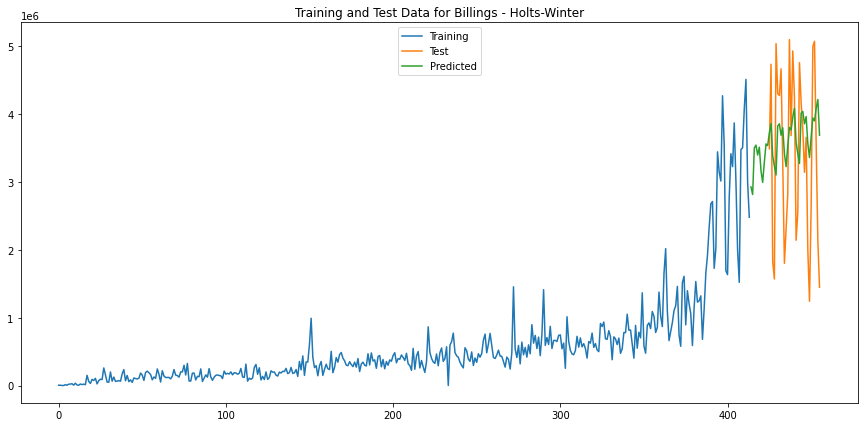

In [51]:
# plot the train and test data using matplotlib.
plt.figure(figsize=(15,7))
plt.plot(train, label='Training')
plt.plot(test, label='Test')
plt.plot(predictions, label='Predicted')
plt.legend(loc = 'upper center')
plt.title("Training and Test Data for Billings - Holts-Winter")
plt.show()

In [52]:
# evaluating the accuracy with rmse.
rmse = ((predictions - test) ** 2).mean() ** .5
print("rmse for billings via Holt-winters :", round(rmse))

rmse for billings via Holt-winters : 1188684


In [53]:
# adding the rmse into the final rmse dataframe.
rmse_df.loc['Holts-Winter', 'Billings'] = round(rmse)

### A comparison of all the models we are using :
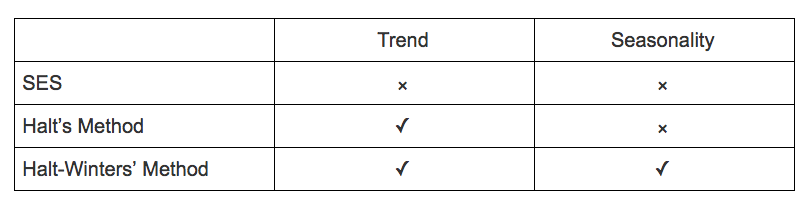

Seasonality and trend observations for SARIMA.


<ipython-input-54-59181b80bb6e>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(train_data['Units Sold'], freq=30)


<Figure size 432x288 with 0 Axes>

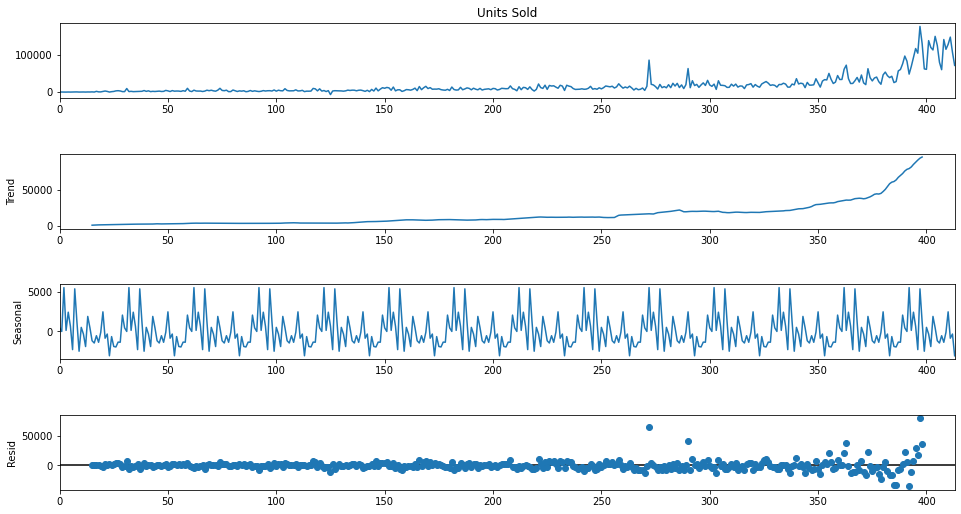

In [54]:
# the seasonal nature of our data.
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(train_data['Units Sold'], freq=30)  
fig = plt.figure() 
fig = decomposition.plot()  
fig.set_size_inches(15, 8)
print("Seasonality and trend observations for SARIMA.")

<ipython-input-55-cf63323a3d38>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(train_data['Billings'], freq=30)


Seasonality and trend observations for SARIMA.


<Figure size 432x288 with 0 Axes>

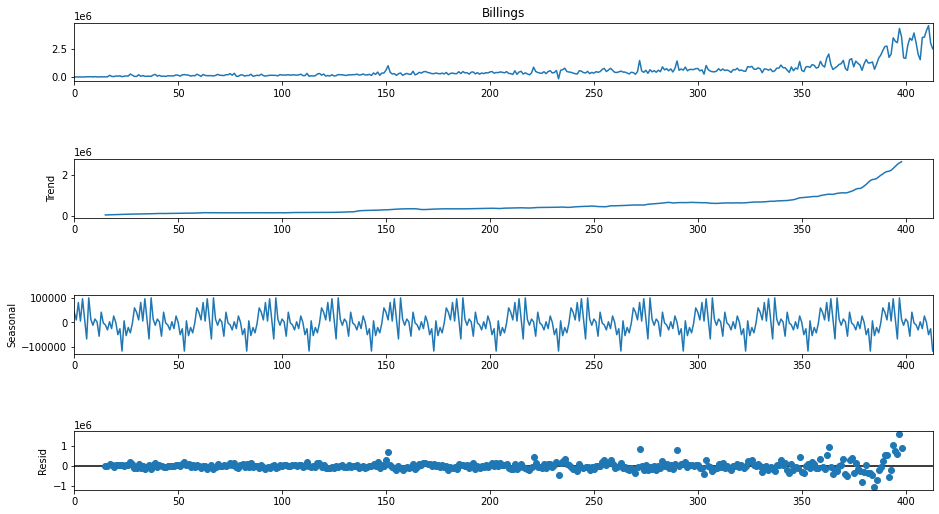

In [55]:
# the seasonal nature of our data.
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(train_data['Billings'], freq=30)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)
print("Seasonality and trend observations for SARIMA.")

   
### Seasonal ARIMA (SARIMA) Analysis :
    Since, we know that the time-series data is impacted by seasonalities, we will revisit the data-set through
    SARIMA. SARIMA analysis is one of the most important models used in forecasting seasonal auto-regressive
    series.

    First, we will train the model on "Units Sold" data.

In [56]:
# import the pmdarima package in python.
from pmdarima import auto_arima

# fitting the defined model on "Units Sold" data. 
Arima_model_units=auto_arima(units_train_data['Units Sold'], start_p=0, start_q=0, max_p=8, max_q=8, 
                       start_P=0, start_Q=0, max_P=8, max_Q=8, 
                       m=1, seasonal=True, trace=True, d=1, D=1, trend = 't', 
                       error_action='warn', suppress_warnings=True, random_state = 20, n_fits=30)

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=9011.039, BIC=9019.086, Time=0.057 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=8986.342, BIC=8998.412, Time=0.019 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=8910.516, BIC=8922.586, Time=0.076 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=9011.039, BIC=9019.086, Time=0.015 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=8895.711, BIC=8911.805, Time=0.119 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=8878.391, BIC=8898.509, Time=0.153 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=8926.844, BIC=8942.937, Time=0.066 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=8880.390, BIC=8904.531, Time=0.245 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=8877.794, BIC=8901.935, Time=0.398 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=8880.457, BIC=8900.574, Time=0.255 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercep

In [57]:
# print a summary for the Arima model. 
# we make sure that the p-values are small so that we can reject the null-hypotheses.
Arima_model_units.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  414
Model:               SARIMAX(6, 1, 4)   Log Likelihood               -4363.827
Date:                Thu, 06 Aug 2020   AIC                           8751.655
Time:                        19:26:37   BIC                           8799.936
Sample:                             0   HQIC                          8770.751
                                - 414                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          5.5399      2.787      1.988      0.047       0.077      11.002
ar.L1         -0.0670      0.073     -0.922      0.356      -0.209       0.075
ar.L2         -1.1371      0.035    -32.468      0.000      -1.206      -1.068
ar.L3         -0.0949      0.068     -1.393      0.164      -0.228       0.039
ar.L4         -0.8719      0.054    -16.174      0.000      -0.978      -0.766
ar.L5         -0.5112      0.036    -14.042      0.000      -0.583      -0.440
ar.L6         -0.3593      0.054     -6.636      0.000      -0.465      -0.253
ma.L1         -0.5120      0.070     -7.363      0.000      -0.648      -0.376
ma.L2          0.9723      0.056     17.276      0.000       0.862       1.083
ma.L3         -0.5731      0.057    -10.060      0.000      -0.685      -0.461
ma.L4          0.6416      0.046     13.813      0.000       0.551       0.733
sigma2      9.559e+07   9.56e-07      1e+14      0.000    9.56e+07    9.56e+07
===================================================================================
Ljung-Box (Q):                       54.09   Jarque-Bera (JB):              6425.68
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):              42.38   Skew:                             2.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.93e+28. Standard errors may be unstable.
"""

In [58]:
# making a prediction on the test data with the fit model.
test_data['Units_forecast_SARIMA'] = Arima_model_units.predict(n_periods=73)
predictions=test_data.loc[:455 , 'Units_forecast_SARIMA']
test=(units_test_data.loc[:455,'Units Sold'])
train = units_train_data['Units Sold']

<ipython-input-58-8e759c0220b1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Units_forecast_SARIMA'] = Arima_model_units.predict(n_periods=73)


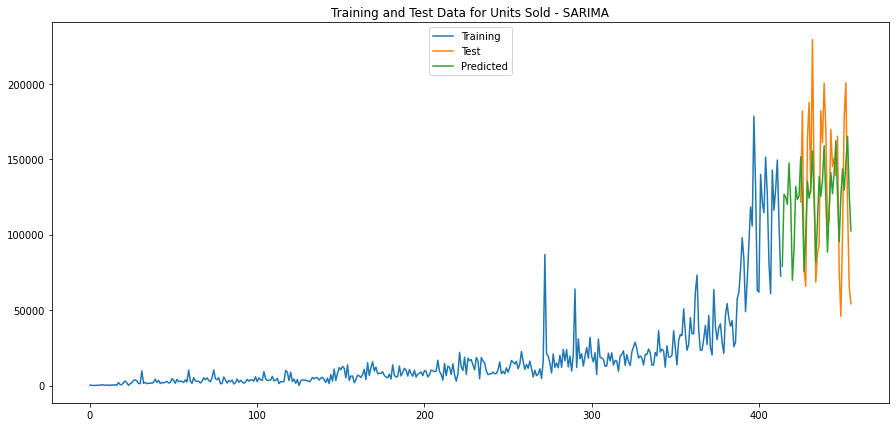

In [59]:
# plot the train and test data using matplotlib.
plt.figure(figsize=(15,7))
plt.plot(train, label='Training')
plt.plot(test, label='Test')
plt.plot(predictions, label='Predicted')
plt.legend(loc = 'upper center')
plt.title("Training and Test Data for Units Sold - SARIMA")
plt.show()

In [60]:
# calculating the rmse for SARIMA model and adding the values into the rmse dataframe. 

rmse = ((predictions - test) ** 2).mean() ** .5
rmse_df.loc['SARIMA', 'Units_Sold'] = round(rmse)


    Similarly, we will train the model on "Billings" data using SARIMA.

In [61]:
# fitting the defined model on "Billings" data. 
Arima_model_billings=auto_arima(billings_train_data['Billings'], start_p=1, start_q=1, max_p=8, max_q=8, 
                       start_P=0, start_Q=0, max_P=8, max_Q=8, 
                       m=14, seasonal=True, trace=True, d=1, D=1, trend = 't', 
                       error_action='warn', suppress_warnings=True, random_state = 20, n_fits=30)

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,0,14) [intercept=True]; AIC=11147.322, BIC=11163.278, Time=0.423 seconds
Fit ARIMA(0,1,0)x(0,1,0,14) [intercept=True]; AIC=11252.195, BIC=11260.173, Time=0.039 seconds
Fit ARIMA(1,1,0)x(1,1,0,14) [intercept=True]; AIC=11131.213, BIC=11147.169, Time=0.447 seconds
Fit ARIMA(0,1,1)x(0,1,1,14) [intercept=True]; AIC=11082.963, BIC=11098.919, Time=0.474 seconds
Fit ARIMA(0,1,0)x(0,1,0,14) [intercept=False]; AIC=11252.195, BIC=11260.173, Time=0.041 seconds
Fit ARIMA(0,1,1)x(0,1,0,14) [intercept=True]; AIC=11148.924, BIC=11160.891, Time=0.101 seconds
Fit ARIMA(0,1,1)x(1,1,1,14) [intercept=True]; AIC=11084.941, BIC=11104.885, Time=1.049 seconds
Fit ARIMA(0,1,1)x(0,1,2,14) [intercept=True]; AIC=11084.950, BIC=11104.895, Time=1.456 seconds
Fit ARIMA(0,1,1)x(1,1,0,14) [intercept=True]; AIC=11088.734, BIC=11104.690, Time=1.115 seconds
Fit ARIMA(0,1,1)x(1,1,2,14) [intercept=True]; AIC=11086.902, BIC=11110.836, Time=3.110 seconds
Fit AR

In [62]:
# making a prediction on the test data with the fit model.
test_data['Billings_forecast_SARIMA'] = Arima_model_billings.predict(n_periods=73)
predictions=test_data.loc[:455 , 'Billings_forecast_SARIMA']
test=(billings_test_data.loc[:455,'Billings'])
train = billings_train_data['Billings']

<ipython-input-62-043289d75601>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Billings_forecast_SARIMA'] = Arima_model_billings.predict(n_periods=73)


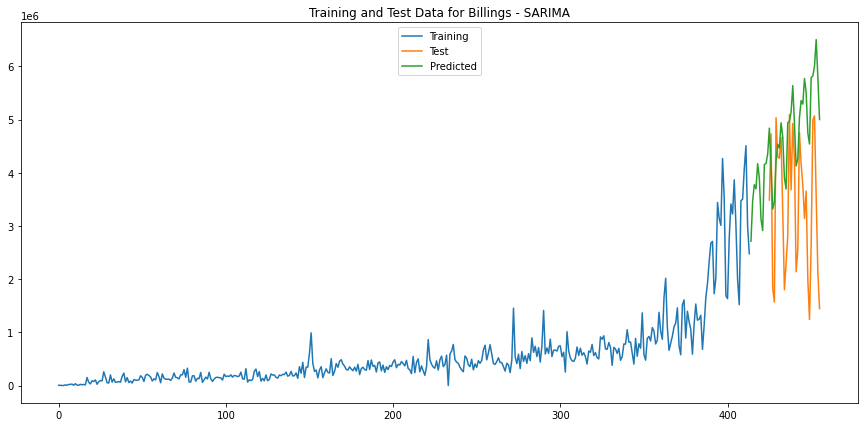

In [63]:
# plot the train and test data using matplotlib.
plt.figure(figsize=(15,7))
plt.plot(train, label='Training')
plt.plot(test, label='Test')
plt.plot(predictions, label='Predicted')
plt.legend(loc = 'upper center')
plt.title("Training and Test Data for Billings - SARIMA")
plt.show()

In [64]:
# calculating the rmse for SARIMA model and adding the values into the rmse dataframe. 
rmse = ((predictions - test) ** 2).mean() ** .5
print("rmse for billings via SARIMA :", round(rmse))

rmse for billings via SARIMA : 1888541


In [65]:
rmse_df.loc['SARIMA', 'Billings'] = round(rmse)

In [66]:
print("The final RMSE scores for comparison:")
rmse_df

The final RMSE scores for comparison:


,Units_Sold,Billings
Holts-Winter,56530.0,1188684.0
SARIMA,41005.0,1888541.0


###   Seasonality analysis : 

    We took the best values for seasoning both our models, viz., Holt-Winters and SARIMA. 
    Seasoning was done on the basis of monthly, weekly and daily data and taken the best results from the plots 
    that were generated in the back-end. We can thus infer that:
- Holt-Winters - seasonality of 30 (monthly) was used for Units Sold.
- Holt-Winters - seasonality of 14 (weekly) was used for Billings.
- SARIMA - seasonality of 1 (daily) was used for Units Sold.
- SARIMA - seasonality of 14 (weekly) was used for Billings.



 
    
    
    We infer that the RMSE scores for Units_Sold in SARIMA and that for Billings in Holt-Winters are the smallest.
    We will use the corresponding models for our estimations as the RMSE values were the lowest:
    
 -  Units Sold - SARIMA Analysis
 - Billings - Holt-Winters Method
 
 

### Assigning the values for final Q4 2013 estimation :

    We will further use the above specified models to calculate our North America Q4 2013 data. 

In [67]:
# use a new dataframe for Q4 2013 for storing values for "Local" deals.
local_final_df = model_df.copy()

In [68]:
# separate by Units Sold for making the final dataframe without the 11 estimated dates.
units = test_data[(test_data['Start Date']>='2013-10-20') & (test_data['Start Date']<='2013-10-30')]['Units_forecast_SARIMA']
# separate by Billings for making the final dataframe without the 11 estimated dates.
billings = test_data[(test_data['Start Date']>='2013-10-20') & (test_data['Start Date']<='2013-10-30')]['Billings_forecast_Holt']

In [69]:
# assign the "Units Sold" value to the Local dataframe made.
local_final_df.loc[(local_final_df['Start Date']>='2013-10-20') & (local_final_df['Start Date']<='2013-10-30'), 'Units Sold'] = units
# assign the "Billings" value to the Local dataframe made.
local_final_df.loc[(local_final_df['Start Date']>='2013-10-20') & (local_final_df['Start Date']<='2013-10-30'), 'Billings'] = billings

In [70]:
# make a new dataframe for Q4 2013.
final_df = agg_df.copy()
# drop the default index for better readability.
final_df.drop(index = 'Local', inplace = True)
# reset the index.
final_df.reset_index(inplace = True)

In [71]:
local_final_df['Segment'] = 'Local'

In [72]:
final_df = final_df.append(local_final_df)
print("The final estimated data looks like:")
final_df

The final estimated data looks like:


,Segment,Start Date,Units Sold,Billings
0,Goods,2012-10-30,663.918,1.244360e+04
1,Goods,2013-03-25,6.670,2.867433e+02
2,Goods,2013-03-26,-9.476,-8.946052e+02
3,Goods,2013-03-27,69.046,2.565742e+03
4,Goods,2013-03-28,1.334,1.199266e+01
...,...,...,...,...
482,Local,2013-12-27,50686.400,1.160202e+06
483,Local,2013-12-28,56382.900,1.106641e+06
484,Local,2013-12-29,12952.050,3.988871e+05
485,Local,2013-12-30,15052.350,4.200016e+05


### Estimate XYZ Capital's 4Q13 North America Gross billings by segment (Local, Travel, and Goods) :

In [73]:
segments = ['Travel', 'Goods', 'Local']
months = ['2013-10','2013-11', '2013-12']
Q4_2013_bil_df = pd.DataFrame()
Q4_2013_ut_df = pd.DataFrame()
for segment in segments:
    for month in months:
        goods_df = final_df[(final_df['Segment'] == segment) & 
                            (final_df['Start Date'].astype(str).str.contains(month))]
        Q4_2013_bil_df.loc[segment, month] = str(round(goods_df.Billings.sum()))
        Q4_2013_ut_df.loc[segment, month] = str(round(goods_df['Units Sold'].sum()))
        

In [74]:
print("Final Billings Q4 2013 E (Estimation):")
Q4_2013_bil_df = pd.concat([Q4_2013_bil_df,pd.DataFrame(Q4_2013_bil_df.sum(axis=0),columns=['Total']).T])
Q4_2013_bil_df

Final Billings Q4 2013 E (Estimation):


,2013-10,2013-11,2013-12
Travel,20237034,25095952,22688556
Goods,62470214,115005646,98789035
Local,97800159,101766642,67018251
Total,2.0237e+23,2.5096e+25,2.26886e+23


In [75]:
print("Final Units Sold Q4 2013 E (Estimation):")
Q4_2013_ut_df = pd.concat([Q4_2013_ut_df,pd.DataFrame(Q4_2013_ut_df.sum(axis=0),columns=['Total']).T])
Q4_2013_ut_df

Final Units Sold Q4 2013 E (Estimation):


,2013-10,2013-11,2013-12
Travel,88923,145493,134367
Goods,2437271,4088846,3664275
Local,3555503,3955668,2451172
Total,8.89232e+18,1.45493e+19,1.34367e+19


### Buy or Sell Recommendation :

    This will be our final step towards the project. Now that we have our Q4 2013 Estimations for Gross 
    Billings, Gross Units and New deals started, we need to analyze the data to draw a conclusion whether
    to buy, sell or retaing the stocks by XYZ Capital. 

   
    Gathering information from XYZ Capital's 2012 annual report and market research reports from Morgan Stanley,
    J.P.Morgan and Deutsche Bank, we can observe that the Year on Year is the main method used to draw conclusions
    over stock recommendation. However, we don't have the yearly data for the year 2012. Hence, we can lead our 
    estimation from evaluating the Quarter on Quarter Analysis technique for gross billings. 
    
    
    QoQ will be calculated by: 
 QoQ % = $ \frac { Gross Billings(Q4_{2013} - Q4_{2012})}  { Q4_{2012})}$ x 100
 
 
     The following estimates were calculated in Excel:
     
     1) North America Gross Billings for Q4 2013:
 <h3 align="center">
  <img src="images/q4gb.png" width="400">
</h3>

     2) North America Units Sold for Q4 2013:
 <h3 align="center">
  <img src="images/q4ut.png" width="400">
</h3>

     3) US New Deals started for Q4 2013:
<h3 align="center">
  <img src="images/q4nd.png" width="400">
</h3>

     4) US Gross billings trend for all quarters:
<h3 align="center">
  <img src="images/plotgb.png" width="700">
</h3>

     5) US Gross billings for Q3 2013:
<h3 align="center">
  <img src="images/q3gb.png" width="400">
</h3>

     6) A solid comparison of all other estimates that we were provided:
<h3 align="center">
  <img src="images/compare.png" width="600">
</h3>

     7) QoQ growth rate plot: 
<h3 align="center">
  <img src="images/growth.png" width="700">
</h3>
 
     8) Q1 2014 Estimation: 
     
     We will make an estimation for Q1 2014 as well using a Simple Exponential Model (using Excel).
     The R-squared value verifies the accuracy of this model. 
     
<h3 align="center">
  <img src="images/q414gb.png" width="800">
</h3>     
     
      
     From XYZ Capital's 2012 annual report, we inferred some characteristics from their business and risk factors:
     
     1) Their financial results will be adversely affected if they are unable to execute on their marketing
     strategy.
     2) If they fail to retain their existing customers or acquire new customers, their revenue and business will
     be harmed.
     2) They may incur losses in the future as they expand their business.
     
     This might give valid reasons for an overall negative growth rate in Q4 2013 Gross billings.
     
     The growth rate from our Q4 2013 Estimation may be bad but when we look beyond the earnings, we will see that
     the new deals that were estimated continue to grow in almost all the months after October 2013. 
     Thus, with XYZ Capital's business fundamentals remaining solid, we expect their stock to rebound soon as the
     company adjusts to perform better in the next quarter as observed from the Q4 2014 estimation. 
  
### Conclusion : Our recommendation is to  **Buy** XYZ's stock. 


### References: 

 - https://www.patriotsoftware.com/blog/accounting/year-year-growth-calculate/
 - https://business.inquirer.net/229677/quarterly-earnings-reports-affect-stock-prices#ixzz6Tj8zIMGn
 - https://towardsdatascience.com/time-series-forecasting-with-sarima-in-python-cda5b793977b
 - https://medium.com/datadriveninvestor/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1

In [76]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))